#### # Análisis de microbiota con grafos esparsos y dinámica de osciladores

Este cuaderno desarrolla un pipeline completo para analizar datos de microbiota **sin submuestreo**.  El objetivo es clusterizar las muestras usando distintas vistas de similitud (diversidad alfa, CLR–coseno, PPMI) y fusionarlas en un grafo esparso, sobre el cual se simula la dinámica de osciladores de **Kuramoto** para obtener una afinidad de fase y detectar comunidades.

**Requisitos clave:**

- Usar **todas** las OTUs y **todas** las muestras disponibles.
- Evitar densificar matrices de grafos (no usar `.toarray()` sobre grafos grandes).
- Automatizar la detección del archivo OTU y manejar formatos/duplicados.
- Construir las vistas de similitud (alfa, CLR, PPMI) y fusionarlas con pesos.
- Implementar Kuramoto con integrador Heun/RK2 y afinidad de fase en bloques.
- Clusterizar con **Louvain** cuando sea posible; usar **Label Propagation** en caso de error, y **Leiden** opcionalmente.
- Generar visualizaciones y un análisis de estabilidad basado en NMI.


In [2]:

# Bloque 1: Configuración general
import sys
import subprocess
import numpy as np
import pandas as pd
import scipy.sparse as sp
import math
import random
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Función para instalar paquetes silenciosamente
def silent_install(package):
    try:
        __import__(package if package != 'python-louvain' else 'community')
        print(f"{package} ya está instalado.")
        return True
    except Exception:
        try:
            print(f"Instalando {package}…")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '--quiet'])
            print(f"{package} instalado correctamente.")
            return True
        except Exception as e:
            print(f"No se pudo instalar {package}: {e}")
            return False

# Instalar paquetes requeridos
for pkg in ['networkx', 'python-louvain']:
    silent_install(pkg)
    
# Instalar opcionales
tmp = silent_install('python-igraph')
if tmp:
    silent_install('leidenalg')

# Importar después de instalación

try:
    import networkx as nx
    
    # Verificar si networkx tiene la función from_scipy_sparse_matrix; en versiones mínimas puede faltar
    if not hasattr(nx, 'from_scipy_sparse_matrix'):
        print('NetworkX no soporta from_scipy_sparse_matrix; no se usará.')
        nx = None
except Exception:
    nx = None
try:
    import community as community_louvain
except Exception:
    community_louvain = None
try:
    import igraph as ig
    import leidenalg
except Exception:
    ig = None
    leidenalg = None
from sklearn.metrics import normalized_mutual_info_score

# Semillas y rutas
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
PROJECT_ROOT = Path('.').resolve()
DATA_DIR = PROJECT_ROOT / 'Datos'
RESULTS_DIR = PROJECT_ROOT / 'Resultados'
RESULTS_DIR.mkdir(exist_ok=True)

# Parámetros por defecto
TOPK = 12
weights = {'alpha': 0.35, 'ppmi': 0.45, 'clr': 0.20}
Kg_default_vals = np.geomspace(0.7, 1.8, 6)
kuramoto_defaults = dict(dt=0.02, T=1400, burn=500, alpha=0.18, seed=7, normalize_by_degree=True)
phase_affinity_defaults = dict(stride=3, chunk_n=256, use_float32=True)
ANONYMIZE_IDS = False

print(f"Proyecto inicializado en {PROJECT_ROOT}")
print(f"Datos en {DATA_DIR}")
print(f"Resultados en {RESULTS_DIR}")


networkx ya está instalado.
python-louvain ya está instalado.
Instalando python-igraph…
python-igraph instalado correctamente.
leidenalg ya está instalado.
NetworkX no soporta from_scipy_sparse_matrix; no se usará.
Proyecto inicializado en D:\Proyectos\Proyectos Python\Clustering_Microbiota
Datos en D:\Proyectos\Proyectos Python\Clustering_Microbiota\Datos
Resultados en D:\Proyectos\Proyectos Python\Clustering_Microbiota\Resultados


In [3]:

# Bloque 2: Autodescubrimiento del archivo OTU
from pathlib import Path

def guess_otu_path(data_dir: Path):
    
    # Buscar archivo con extensión .otus
    for file in data_dir.iterdir():
        if file.is_file() and file.suffix.lower() == '.otus':
            return file, False
            
    # Buscar archivos que contengan 'otu'
    candidates = []
    for file in data_dir.iterdir():
        if file.is_file() and 'otu' in file.stem.lower() and file.suffix.lower() in {'.tsv', '.csv', '.txt'}:
            candidates.append(file)
    if candidates:
        return candidates[0], False
        
    # Generar sintético
    print("No se encontró archivo OTU; generando datos sintéticos…")
    n_otus, n_samples = 50, 20
    rng = np.random.default_rng(GLOBAL_SEED)
    synthetic_counts = rng.poisson(lam=5, size=(n_otus, n_samples))
    synthetic_path = data_dir / 'synthetic.otus'
    synthetic_df = pd.DataFrame(synthetic_counts, columns=[f'sample_{i:03d}' for i in range(n_samples)])
    synthetic_df.insert(0, 'OTU_ID', [f'OTU_{i:03d}' for i in range(n_otus)])
    synthetic_df.to_csv(synthetic_path, sep='	', index=False)
    return synthetic_path, True

otu_path, synthetic_data = guess_otu_path(DATA_DIR)
print(f"Archivo OTU detectado: {otu_path.name} (sintético={synthetic_data})")


Archivo OTU detectado: otu_data.otus (sintético=False)


In [4]:

# Bloque 3: Lectura robusta del OTU
import pandas as pd
import numpy as np
import scipy.sparse as sp


def load_otu_data(otu_file: Path):
    # Detectar delimitador
    with open(otu_file, 'rb') as f:
        header = f.readline().decode('utf-8', errors='ignore')
        if ',' in header and header.count(',') > header.count('	'):
            delim = ','
        elif '	' in header:
            delim = '	'
        else:
            delim = None
    try:
        df = pd.read_csv(otu_file, sep=delim, engine='python')
    except Exception:
        df = pd.read_csv(otu_file, sep=None, engine='python')
    # Quitar columna taxonomy si existe
    for col in df.columns:
        if col.lower() in {'taxonomy','taxonomyid','tax'}:
            df = df.drop(columns=[col])
            break
    first_col = df.columns[0]
    first_vals = df[first_col].astype(str).values
    def looks_like_sample_id(x):
        return any(c.isalpha() for c in x) and '_' in x
    orientation = 'samples_as_rows' if all(looks_like_sample_id(str(v)) for v in first_vals[:min(len(first_vals), 10)]) else 'otus_as_rows'
    if orientation == 'samples_as_rows':
        sample_ids = df[first_col].astype(str).tolist()
        otu_df = df.drop(columns=[first_col])
        otu_ids = otu_df.columns.astype(str).tolist()
        counts = otu_df.values.astype(float).T
    else:
        otu_ids = df[first_col].astype(str).tolist()
        otu_df = df.drop(columns=[first_col])
        sample_ids = otu_df.columns.astype(str).tolist()
        counts = otu_df.values.astype(float)
    # Agrupar OTUs duplicadas
    if len(set(otu_ids)) != len(otu_ids):
        temp_df = pd.DataFrame(counts, index=otu_ids, columns=sample_ids)
        temp_df = temp_df.groupby(level=0).sum()
        otu_ids = temp_df.index.astype(str).tolist()
        counts = temp_df.values.astype(float)
    # Eliminar OTUs vacías
    counts_sum = counts.sum(axis=1)
    mask_nonzero = counts_sum > 0
    counts = counts[mask_nonzero]
    otu_ids = [otu_ids[i] for i, flag in enumerate(mask_nonzero) if flag]
    # Unicidad de sample_ids
    seen = {}
    uniq_sample_ids = []
    for sid in sample_ids:
        if sid not in seen:
            seen[sid] = 1
            uniq_sample_ids.append(sid)
        else:
            seen[sid] += 1
            uniq_sample_ids.append(f"{sid}_{seen[sid]}")
    sample_ids = uniq_sample_ids
    counts_matrix = sp.csr_matrix(counts)
    print(f"OTU cargado: {counts_matrix.shape[0]} OTUs x {counts_matrix.shape[1]} muestras")
    return counts_matrix, otu_ids, sample_ids

counts_matrix, otu_ids, sample_ids = load_otu_data(otu_path)

df_preview = pd.DataFrame(
    counts_matrix[:6, :6].toarray(),
    index=otu_ids[:6],
    columns=sample_ids[:6]
)
print("\nVista previa de los primeros datos cargados:")
print(df_preview)


OTU cargado: 4720 OTUs x 441 muestras

Vista previa de los primeros datos cargados:
          MI_001_H  MI_002_H  MI_003_H  MI_004_H  MI_005_H  MI_006_H
Otu00001     354.0     168.0      19.0     264.0       0.0       3.0
Otu00002     817.0       9.0     174.0    1816.0       2.0       0.0
Otu00003      50.0     131.0    6211.0     159.0       0.0    3536.0
Otu00004      31.0    3005.0      79.0      16.0      12.0      38.0
Otu00005     448.0      68.0    1063.0     110.0     598.0     815.0
Otu00006     547.0   10187.0       0.0       4.0      39.0    1270.0


In [5]:
# Bloque 4: Métricas alfa y similitud
import numpy as np
import pandas as pd


def compute_alpha_metrics(counts: sp.csr_matrix, otu_ids, sample_ids):
    X = counts.toarray()
    X_samp = X.T
    richness = (X_samp > 0).sum(axis=1)
    row_sums = X_samp.sum(axis=1)
    ps = X_samp + 1e-12
    ps = ps / row_sums[:, None]
    shannon = -np.sum(ps * np.log(ps + 1e-16), axis=1)
    simpson = 1.0 - np.sum(ps**2, axis=1)
    alpha_df = pd.DataFrame({'sample_id': sample_ids, 'richness': richness, 'shannon': shannon, 'simpson': simpson})
    for col in ['richness','shannon','simpson']:
        m = alpha_df[col].mean()
        s = alpha_df[col].std(ddof=1)
        alpha_df[col+'_z'] = (alpha_df[col] - m) / (s + 1e-8)
    X_z = alpha_df[['richness_z','shannon_z','simpson_z']].values
    norms = np.linalg.norm(X_z, axis=1)
    norms[norms==0] = 1.0
    X_norm = X_z / norms[:,None]
    sim_alpha = X_norm @ X_norm.T
    np.fill_diagonal(sim_alpha,0.0)
    return sim_alpha, alpha_df

sim_alpha, alpha_df = compute_alpha_metrics(counts_matrix, otu_ids, sample_ids)
print("Matriz de similitud alfa calculada.")

print("\n Métricas alfa por muestra:")
print(alpha_df[['sample_id', 'richness', 'shannon', 'simpson']].head().round(3))

# Mostrar pequeña porción de la matriz de similitud 
n_preview = 6
sub_ids = alpha_df['sample_id'][:n_preview]
sub_sim = sim_alpha[:n_preview, :n_preview]
sub_df = pd.DataFrame(sub_sim, index=sub_ids, columns=sub_ids)

print("\n Submatriz de similitud alfa:")
print(sub_df.round(3))

# Vista rápida del rango de similitudes
print(f"\nRango de similitud: {sim_alpha.min():.3f} a {sim_alpha.max():.3f}")




Matriz de similitud alfa calculada.

 Métricas alfa por muestra:
  sample_id  richness  shannon  simpson
0  MI_001_H       259    3.957    0.959
1  MI_002_H       398    3.445    0.907
2  MI_003_H       127    2.709    0.887
3  MI_004_H       179    3.667    0.935
4  MI_005_H       143    3.510    0.945

 Submatriz de similitud alfa:
sample_id  MI_001_H  MI_002_H  MI_003_H  MI_004_H  MI_005_H  MI_006_H
sample_id                                                            
MI_001_H      0.000     0.434    -0.422     0.616     0.339     0.732
MI_002_H      0.434     0.000    -0.953    -0.440    -0.685     0.932
MI_003_H     -0.422    -0.953     0.000     0.432     0.700    -0.889
MI_004_H      0.616    -0.440     0.432     0.000     0.946    -0.084
MI_005_H      0.339    -0.685     0.700     0.946     0.000    -0.380
MI_006_H      0.732     0.932    -0.889    -0.084    -0.380     0.000

Rango de similitud: -1.000 a 1.000


In [6]:

# Bloque 5: Cálculo de CLR y PPMI
import numpy as np
import scipy.sparse as sp


def compute_clr_similarity(counts: sp.csr_matrix):
    X = counts.toarray()
    X_pseudo = X + 1.0
    prop = X_pseudo / X_pseudo.sum(axis=0, keepdims=True)
    log_prop = np.log(prop)
    clr = log_prop - log_prop.mean(axis=0, keepdims=True)
    Xclr = clr.T
    norms = np.linalg.norm(Xclr, axis=1)
    norms[norms==0] = 1.0
    Xclr_norm = Xclr / norms[:,None]
    sim_clr = Xclr_norm @ Xclr_norm.T
    np.fill_diagonal(sim_clr,0.0)
    return sim_clr

def compute_ppmi_similarity(counts: sp.csr_matrix):
    X = counts.astype(float)
    total = X.sum()
    row_sum = np.array(X.sum(axis=1)).flatten()
    col_sum = np.array(X.sum(axis=0)).flatten()
    X_coo = X.tocoo()
    expected = (row_sum[X_coo.row] * col_sum[X_coo.col]) / total
    with np.errstate(divide='ignore', invalid='ignore'):
        ppmi_data = np.log((X_coo.data * total) / expected)
    ppmi_data[~np.isfinite(ppmi_data)] = 0.0
    ppmi_data = np.maximum(0.0, ppmi_data)
    ppmi_matrix = sp.csr_matrix((ppmi_data, (X_coo.row, X_coo.col)), shape=X.shape)
    M = (ppmi_matrix.T @ ppmi_matrix).toarray()
    norms = np.sqrt(np.diag(M))
    norms[norms==0] = 1.0
    sim_ppmi = M / (norms[:,None] * norms[None,:])
    np.fill_diagonal(sim_ppmi,0.0)
    return sim_ppmi

sim_clr = compute_clr_similarity(counts_matrix)
print("Similitud CLR calculada.")
sim_ppmi = compute_ppmi_similarity(counts_matrix)
print("Similitud PPMI calculada.")

print("\nMatriz de similitud CLR calculada.")

# Mostrar pequeña porción de la matriz de similitud CLR
n_preview = 6
sub_ids = sample_ids[:n_preview]
sub_clr = sim_clr[:n_preview, :n_preview]
sub_df_clr = pd.DataFrame(sub_clr, index=sub_ids, columns=sub_ids)

print("\n Submatriz de similitud CLR:")
print(sub_df_clr.round(3))

# Vista rápida del rango de similitudes
print(f"\nRango de similitud CLR: {sim_clr.min():.3f} a {sim_clr.max():.3f}")

# -----------------------------------------------------

print("\nMatriz de similitud PPMI calculada.")

# Mostrar pequeña porción de la matriz de similitud PPMI
sub_ppmi = sim_ppmi[:n_preview, :n_preview]
sub_df_ppmi = pd.DataFrame(sub_ppmi, index=sub_ids, columns=sub_ids)

print("\n Submatriz de similitud PPMI:")
print(sub_df_ppmi.round(3))

# Vista rápida del rango de similitudes
print(f"\nRango de similitud PPMI: {sim_ppmi.min():.3f} a {sim_ppmi.max():.3f}")

Similitud CLR calculada.
Similitud PPMI calculada.

Matriz de similitud CLR calculada.

 Submatriz de similitud CLR:
          MI_001_H  MI_002_H  MI_003_H  MI_004_H  MI_005_H  MI_006_H
MI_001_H     0.000     0.542     0.523     0.549     0.326     0.574
MI_002_H     0.542     0.000     0.423     0.430     0.234     0.573
MI_003_H     0.523     0.423     0.000     0.570     0.337     0.486
MI_004_H     0.549     0.430     0.570     0.000     0.343     0.481
MI_005_H     0.326     0.234     0.337     0.343     0.000     0.242
MI_006_H     0.574     0.573     0.486     0.481     0.242     0.000

Rango de similitud CLR: 0.000 a 0.906

Matriz de similitud PPMI calculada.

 Submatriz de similitud PPMI:
          MI_001_H  MI_002_H  MI_003_H  MI_004_H  MI_005_H  MI_006_H
MI_001_H     0.000     0.419     0.341     0.415     0.261     0.454
MI_002_H     0.419     0.000     0.271     0.335     0.238     0.423
MI_003_H     0.341     0.271     0.000     0.426     0.326     0.290
MI_004_H     0.41

In [13]:
sim_fused = (sim_alpha + sim_ppmi + sim_clr) / 3.0
print(sim_fused)

[[ 0.          0.46517979  0.14715948 ...  0.70629251  0.16590487
   0.42520372]
 [ 0.46517979  0.         -0.08629883 ...  0.42345127  0.00978143
   0.01154354]
 [ 0.14715948 -0.08629883  0.         ...  0.08544358  0.60652746
   0.48199243]
 ...
 [ 0.70629251  0.42345127  0.08544358 ...  0.          0.14050466
   0.44206286]
 [ 0.16590487  0.00978143  0.60652746 ...  0.14050466  0.
   0.42284532]
 [ 0.42520372  0.01154354  0.48199243 ...  0.44206286  0.42284532
   0.        ]]


Grafo fusionado: forma (441, 441), nnz = 6962

=== α-diversidad ===
Nodos: 441 | Aristas (nnz): 6598 | Grado medio: 14.71 | Grado min/max: 9/21

 Submatriz de adyacencia (primeros nodos por grado):
          MI_297_H  MI_063_H  MI_248_H  MI_102_H  MI_043_H  MI_153_H  \
MI_297_H     0.000       0.0     0.992       0.0       0.0       0.0   
MI_063_H     0.000       0.0     0.000       0.0       0.0       0.0   
MI_248_H     0.992       0.0     0.000       0.0       0.0       0.0   
MI_102_H     0.000       0.0     0.000       0.0       0.0       0.0   
MI_043_H     0.000       0.0     0.000       0.0       0.0       0.0   
MI_153_H     0.000       0.0     0.000       0.0       0.0       0.0   
MI_318_H     0.000       0.0     0.000       0.0       0.0       0.0   
MI_361_H     0.000       0.0     0.000       0.0       0.0       0.0   
MI_309_H     0.000       0.0     0.000       0.0       0.0       0.0   
MI_069_H     0.992       0.0     1.000       0.0       0.0       0.0   
MI_459_H  

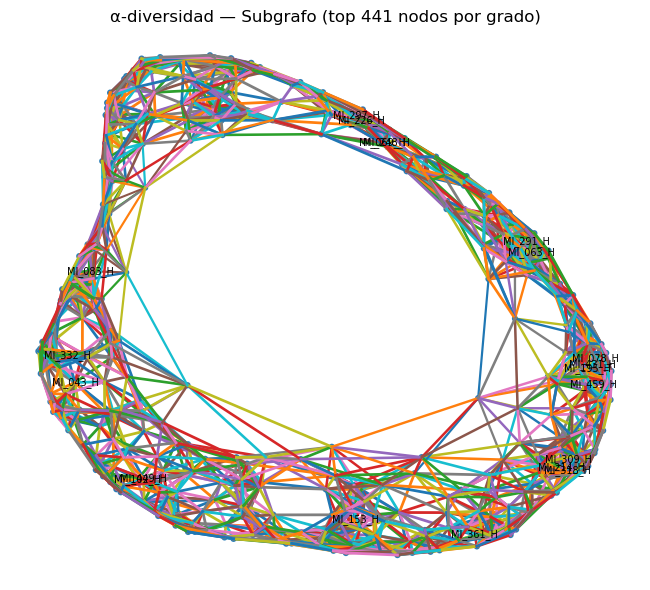


=== PPMI ===
Nodos: 441 | Aristas (nnz): 8910 | Grado medio: 14.06 | Grado min/max: 6/96

 Submatriz de adyacencia (primeros nodos por grado):
           MI_008_H1  MI_235_H  MI_046_H  MI_024_H  MI_146_H  MI_012_H  \
MI_008_H1      0.000     0.000     0.804     0.867     0.772     0.000   
MI_235_H       0.000     0.000     0.000     0.784     0.797     0.000   
MI_046_H       0.804     0.000     0.000     0.795     0.000     0.780   
MI_024_H       0.867     0.784     0.795     0.000     0.775     0.000   
MI_146_H       0.772     0.797     0.000     0.775     0.000     0.000   
MI_012_H       0.000     0.000     0.780     0.000     0.000     0.000   
MI_144_H       0.000     0.000     0.000     0.000     0.811     0.000   
MI_017_H       0.786     0.774     0.806     0.000     0.000     0.795   
MI_309_H       0.000     0.784     0.000     0.000     0.000     0.000   
MI_342_H       0.779     0.000     0.759     0.000     0.000     0.000   
MI_028_H       0.793     0.000     0.765  

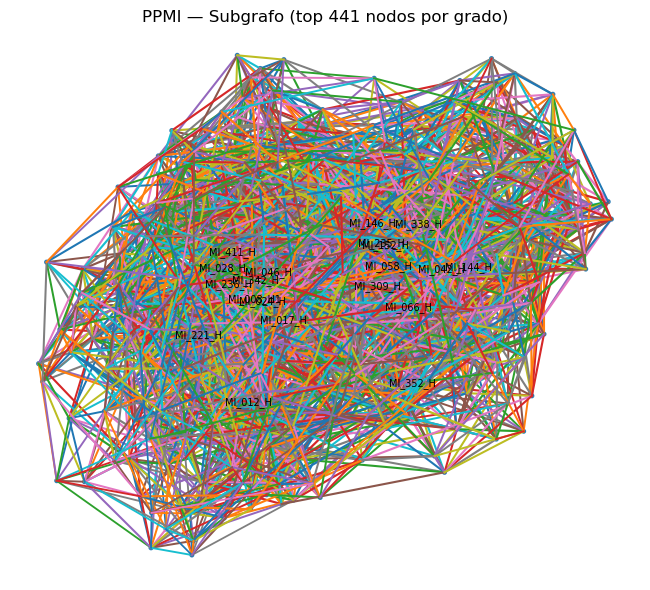


=== CLR ===
Nodos: 441 | Aristas (nnz): 8614 | Grado medio: 14.05 | Grado min/max: 7/72

 Submatriz de adyacencia (primeros nodos por grado):
           MI_008_H1  MI_242_H  MI_042_H  MI_342_H  MI_236_H  MI_129_H  \
MI_008_H1      0.000     0.000     0.000     0.777     0.000     0.809   
MI_242_H       0.000     0.000     0.000     0.000     0.000     0.000   
MI_042_H       0.000     0.000     0.000     0.000     0.000     0.772   
MI_342_H       0.777     0.000     0.000     0.000     0.776     0.000   
MI_236_H       0.000     0.000     0.000     0.776     0.000     0.000   
MI_129_H       0.809     0.000     0.772     0.000     0.000     0.000   
MI_066_H       0.000     0.000     0.823     0.000     0.000     0.000   
MI_218_H       0.000     0.000     0.000     0.770     0.820     0.000   
MI_109_H       0.770     0.000     0.000     0.000     0.000     0.766   
MI_159_H       0.000     0.000     0.772     0.000     0.000     0.000   
MI_352_H       0.000     0.819     0.790   

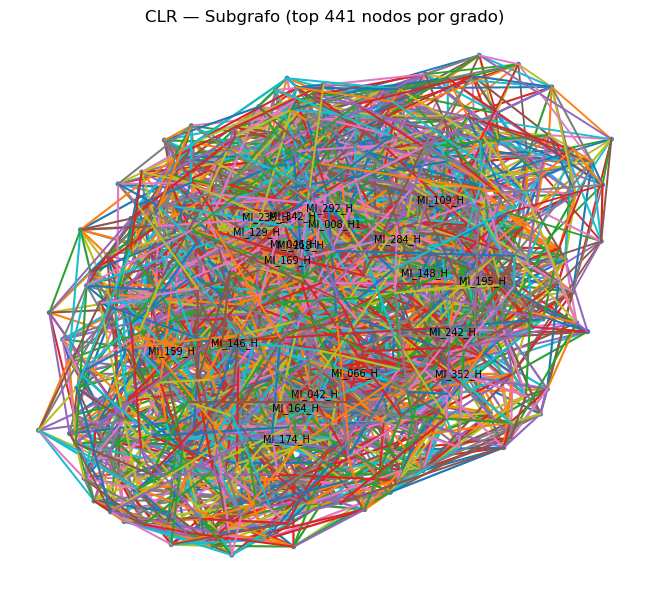


=== Fusión ponderada ===
Nodos: 441 | Aristas (nnz): 19026 | Grado medio: 14.29 | Grado min/max: 9/63

 Submatriz de adyacencia (primeros nodos por grado):
           MI_008_H1  MI_235_H  MI_046_H  MI_024_H  MI_146_H  MI_012_H  \
MI_008_H1      0.000     0.000     0.517     0.902     0.347     0.000   
MI_235_H       0.000     0.000     0.000     0.353     0.359     0.000   
MI_046_H       0.517     0.000     0.000     0.510     0.000     0.506   
MI_024_H       0.902     0.353     0.510     0.000     0.502     0.000   
MI_146_H       0.347     0.359     0.000     0.502     0.000     0.000   
MI_012_H       0.000     0.000     0.506     0.000     0.000     0.000   
MI_042_H       0.000     0.692     0.000     0.153     0.508     0.000   
MI_309_H       0.347     0.510     0.000     0.348     0.000     0.000   
MI_342_H       0.506     0.000     0.341     0.000     0.000     0.000   
MI_017_H       0.848     0.349     0.519     0.486     0.000     0.518   
MI_066_H       0.000     0.35

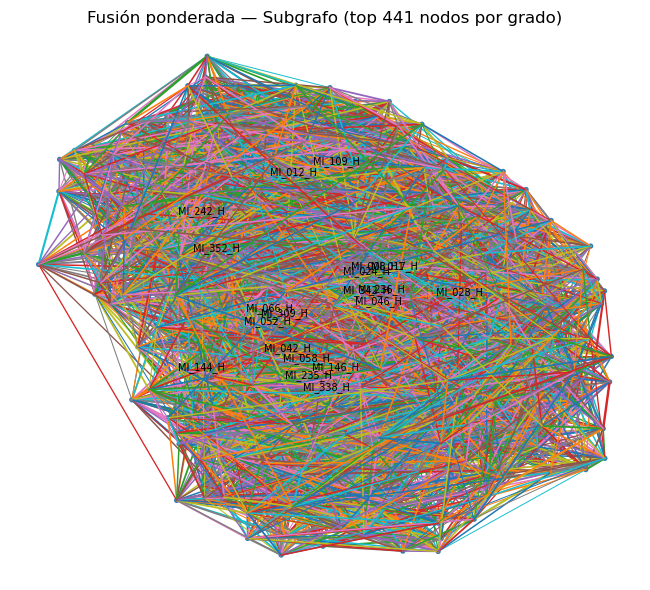


=== Grafo final k-NN mutuo ===
Nodos: 441 | Aristas (nnz): 6962 | Grado medio: 7.11 | Grado min/max: 4/45

 Submatriz de adyacencia (primeros nodos por grado):
           MI_008_H1  MI_042_H  MI_235_H  MI_046_H  MI_146_H  MI_066_H  \
MI_008_H1      0.000     0.000     0.000     0.517     0.000     0.000   
MI_042_H       0.000     0.000     0.692     0.000     0.508     0.529   
MI_235_H       0.000     0.692     0.000     0.000     0.000     0.000   
MI_046_H       0.517     0.000     0.000     0.000     0.000     0.000   
MI_146_H       0.000     0.508     0.000     0.000     0.000     0.525   
MI_066_H       0.000     0.529     0.000     0.000     0.525     0.000   
MI_342_H       0.506     0.000     0.000     0.000     0.000     0.000   
MI_352_H       0.000     0.512     0.000     0.000     0.000     0.513   
MI_236_H       0.000     0.000     0.000     0.000     0.000     0.000   
MI_242_H       0.000     0.000     0.000     0.000     0.000     0.000   
MI_309_H       0.000     

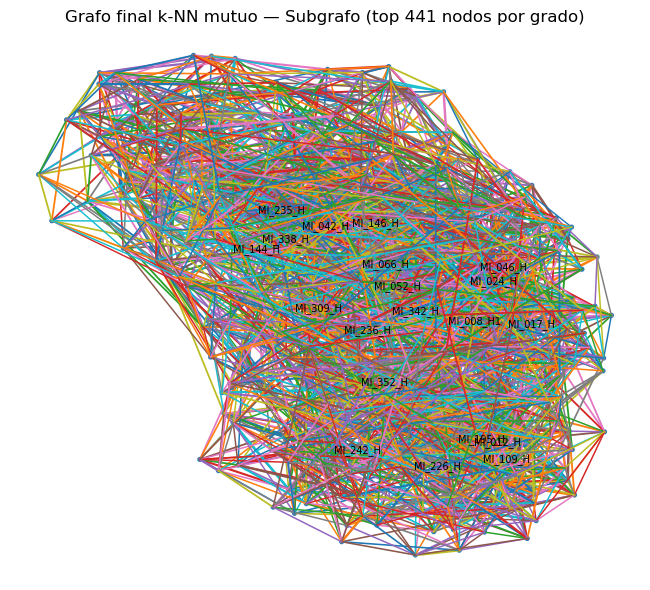

In [10]:

# Bloque 6: Fusión de vistas y grafo final
import scipy.sparse as sp
import numpy as np


def build_knn_graph_from_dense(similarity: np.ndarray, topk: int, mutual: bool=False):
    n = similarity.shape[0]
    neighbor_list=[]
    weight_list=[]
    for i in range(n):
        row = similarity[i].copy()
        row[i] = -np.inf
        if topk < n:
            idxs = np.argpartition(row, -topk)[-topk:]
        else:
            idxs = np.arange(n)
        idxs = idxs[np.argsort(row[idxs])[::-1]]
        #valid = row[idxs] > 0
        #idxs = idxs[valid]
        weights = row[idxs]
        neighbor_list.append(idxs)
        weight_list.append(weights)
    rows=[]
    cols=[]
    data=[]
    for i in range(n):
        for j,w in zip(neighbor_list[i], weight_list[i]):
            if mutual:
                if i in neighbor_list[j]:
                    rows.append(i); cols.append(j); data.append(w)
            else:
                rows.append(i); cols.append(j); data.append(w)
    W = sp.coo_matrix((data,(rows,cols)), shape=(n,n))
    W_sym = W.tocsr().maximum(W.tocsr().transpose())
    return W_sym

def sparse_topk(W: sp.csr_matrix, k:int, mutual: bool=True):
    n = W.shape[0]
    rows=[]; cols=[]; data=[]
    for i in range(n):
        start=W.indptr[i]; end=W.indptr[i+1]
        row_indices=W.indices[start:end]
        row_data=W.data[start:end]
        if len(row_data)==0:
            continue
        if k < len(row_data):
            idxs=np.argpartition(row_data, -k)[-k:]
        else:
            idxs=np.arange(len(row_data))
        idxs = idxs[np.argsort(row_data[idxs])[::-1]]
        sel_indices = row_indices[idxs]
        sel_data = row_data[idxs]
        for j,w in zip(sel_indices, sel_data):
            rows.append(i); cols.append(j); data.append(w)
    Wk = sp.coo_matrix((data,(rows,cols)), shape=W.shape).tocsr()
    if mutual:
        mask = Wk.multiply(Wk.T)
        W_mutual = Wk.multiply(mask>0)
        W_mutual = W_mutual + W_mutual.T
        W_mutual = W_mutual.maximum(W_mutual.T)
        return W_mutual.tocsr()
    else:
        return Wk.maximum(Wk.T).tocsr()

# Construir vistas y fusionar
W_alpha = build_knn_graph_from_dense(sim_alpha, topk=TOPK, mutual=False)
if W_alpha.nnz>0:
    W_alpha_norm = W_alpha.copy(); m = W_alpha_norm.data.max();
    if m>0: W_alpha_norm.data /= m
else:
    W_alpha_norm = W_alpha
W_ppmi = build_knn_graph_from_dense(sim_ppmi, topk=TOPK, mutual=False)
if W_ppmi.nnz>0:
    W_ppmi_norm = W_ppmi.copy(); m = W_ppmi_norm.data.max();
    if m>0: W_ppmi_norm.data /= m
else:
    W_ppmi_norm = W_ppmi
W_clr = build_knn_graph_from_dense(sim_clr, topk=TOPK, mutual=False)
if W_clr.nnz>0:
    W_clr_norm = W_clr.copy(); m = W_clr_norm.data.max();
    if m>0: W_clr_norm.data /= m
else:
    W_clr_norm = W_clr

W_fused = None
for name, Wv in [('alpha', W_alpha_norm),('ppmi',W_ppmi_norm),('clr',W_clr_norm)]:
    weight = weights.get(name,0.0)
    if Wv is not None and Wv.nnz>0 and weight>0:
        W_scaled = Wv.multiply(weight)
        if W_fused is None:
            W_fused = W_scaled.tocsr()
        else:
            W_fused = (W_fused + W_scaled).tocsr()
if W_fused is None:
    n = len(sample_ids)
    W_fused = sp.csr_matrix((n,n))
W_fused_knn = sparse_topk(W_fused, k=TOPK, mutual=False) #Reciprocidad
print(f"Grafo fusionado: forma {W_fused_knn.shape}, nnz = {W_fused_knn.nnz}")


import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

# Seleccionar cuántos nodos dibujar (top por grado, para que sea legible)
n_draw = 441 # ajústalo si quieres
vistas = [
    ("α-diversidad",   W_alpha_norm),
    ("PPMI",           W_ppmi_norm),
    ("CLR",            W_clr_norm),
    ("Fusión ponderada", W_fused),
    ("Grafo final k-NN mutuo", W_fused_knn),
]

# Intentar usar igraph si está disponible
try:
    import igraph as ig
    have_igraph = True
except Exception:
    have_igraph = False

for nombre, W in vistas:
    print(f"\n=== {nombre} ===")
    n = W.shape[0]
    if W.nnz == 0 or n == 0:
        print("Matriz vacía (sin aristas).")
        continue

    # ---- Estadísticas básicas del grafo ----
    deg = np.array(W.sum(axis=1)).ravel()
    print(f"Nodos: {n} | Aristas (nnz): {W.nnz} | Grado medio: {deg.mean():.2f} | "
          f"Grado min/max: {deg.min():.0f}/{deg.max():.0f}")

    # ---- Elegir subgrafo por top grado para dibujar ----
    idx_sorted = np.argsort(-deg)
    sel = idx_sorted[:min(n_draw, n)]
    W_sub = W[sel][:, sel].tocsr()
    ids_sel = [sample_ids[i] for i in sel]

    # ---- Submatriz (como tabla) para ver pesos locales ----
    n_preview = min(12, W_sub.shape[0])  # tabla pequeña
    sub_dense = W_sub[:n_preview, :n_preview].toarray()
    df_sub = pd.DataFrame(sub_dense, index=[ids_sel[i] for i in range(n_preview)],
                          columns=[ids_sel[i] for i in range(n_preview)])
    print("\n Submatriz de adyacencia (primeros nodos por grado):")
    print(df_sub.round(3))

    # ---- Visualización del grafo ----
    # Si no hay igraph, mostramos un heatmap de la submatriz como alternativa
    if not have_igraph:
        try:
            plt.figure(figsize=(5.8, 5.0))
            plt.imshow(W_sub.toarray(), aspect='auto')
            plt.title(f"{nombre} — Heatmap subgrafo ({W_sub.shape[0]} nodos)")
            plt.colorbar()
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"(Aviso) No se pudo dibujar el heatmap: {e}")
        continue

    # ---- Con igraph: construir edgelist (triangular superior para evitar duplicados) ----
    W_ut = sp.triu(W_sub, k=1).tocoo()
    edges = list(zip(W_ut.row.tolist(), W_ut.col.tolist()))
    if len(edges) == 0:
        print("Subgrafo sin aristas para dibujar.")
        continue

    g = ig.Graph(n=W_sub.shape[0])
    g.add_edges(edges)
    g.es["weight"] = W_ut.data.tolist()
    g.vs["name"] = ids_sel
    # tamaños de nodo ~ grado dentro del subgrafo (escala suave)
    deg_sub = np.array(W_sub.sum(axis=1)).ravel()
    node_size = 6 + 12 * (deg_sub / (deg_sub.max() if deg_sub.max() > 0 else 1.0))

    # Layout (Fruchterman-Reingold)
    try:
        layout = g.layout_fruchterman_reingold(niter=200)
    except Exception:
        layout = g.layout("kk")

    # Dibujar con matplotlib (sin estilos de color específicos)
    try:
        coords = np.array(layout.coords)
        plt.figure(figsize=(6.6, 6.0))
        # dibujar aristas
        for (u, v), w in zip(edges, W_ut.data.tolist()):
            x = [coords[u,0], coords[v,0]]
            y = [coords[u,1], coords[v,1]]
            plt.plot(x, y, linewidth=0.5 + 1.5*(w/ (W_ut.data.max() if W_ut.data.size else 1.0)))
        # dibujar nodos
        plt.scatter(coords[:,0], coords[:,1], s=node_size, alpha=0.9)
        # opcional: etiquetas para los 20 más conectados
        top_lab = min(20, len(ids_sel))
        for i in np.argsort(-deg_sub)[:top_lab]:
            plt.text(coords[i,0], coords[i,1], ids_sel[i], fontsize=7, ha='center', va='center')
        plt.title(f"{nombre} — Subgrafo (top {W_sub.shape[0]} nodos por grado)")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"(Aviso) No se pudo dibujar el grafo con igraph: {e}")
        # fallback a heatmap
        try:
            plt.figure(figsize=(5.8, 5.0))
            plt.imshow(W_sub.toarray(), aspect='auto')
            plt.title(f"{nombre} — Heatmap subgrafo ({W_sub.shape[0]} nodos)")
            plt.colorbar()
            plt.tight_layout()
            plt.show()
        except Exception as e2:
            print(f"(Aviso) Tampoco se pudo dibujar el heatmap: {e2}")


In [17]:

# Bloque 7: Kuramoto y afinidad de fase
import numpy as np
import scipy.sparse as sp
import math


def simulate_kuramoto(W: sp.csr_matrix, Kg: float, dt: float, T: int, burn: int, alpha: float=0.18, seed:int=7, normalize_by_degree:bool=True):
    n = W.shape[0]
    rng = np.random.default_rng(seed)
    theta = rng.uniform(0.0, 2.0 * math.pi, size=n)
    natural = rng.normal(loc=0.0, scale=1.0, size=n)
    neighbors=[]; weights_list=[]; degrees=np.array(W.sum(axis=1)).flatten()
    for i in range(n):
        start=W.indptr[i]; end=W.indptr[i+1]
        neighbors.append(W.indices[start:end])
        weights_list.append(W.data[start:end])
    phases=[]
    for step in range(T):
        dtheta = np.zeros(n, dtype=float)
        for i in range(n):
            if len(neighbors[i])==0: continue
            diffs = theta[neighbors[i]] - theta[i]
            if normalize_by_degree:
                denom = degrees[i] if degrees[i]>0 else 1.0
                coupling = Kg / denom
            else:
                coupling = Kg
            dtheta[i] = natural[i] + coupling * np.sum(weights_list[i] * np.sin(diffs))
        k1 = dtheta
        theta_pred = theta + dt * k1
        dtheta2 = np.zeros(n, dtype=float)
        for i in range(n):
            if len(neighbors[i])==0: continue
            diffs2 = theta_pred[neighbors[i]] - theta_pred[i]
            if normalize_by_degree:
                denom = degrees[i] if degrees[i]>0 else 1.0
                coupling = Kg / denom
            else:
                coupling = Kg
            dtheta2[i] = natural[i] + coupling * np.sum(weights_list[i] * np.sin(diffs2))
        theta = theta + dt * dtheta2
        if step >= burn:
            phases.append(theta.copy())
    return np.array(phases)

def phase_affinity(phases: np.ndarray, stride:int=3, chunk_n:int=256, use_float32:bool=True):
    dtype = np.float32 if use_float32 else np.float64
    phases_sub = phases[::stride]
    n_time, n_nodes = phases_sub.shape
    cos_vals = np.cos(phases_sub).astype(dtype)
    sin_vals = np.sin(phases_sub).astype(dtype)
    aff = np.zeros((n_nodes,n_nodes), dtype=dtype)
    for start in range(0,n_nodes,chunk_n):
        end=min(start+chunk_n, n_nodes)
        C = cos_vals.T @ cos_vals[:,start:end]
        S = sin_vals.T @ sin_vals[:,start:end]
        aff[:,start:end] = (C + S) / n_time
    aff = np.maximum(aff, aff.T)
    np.fill_diagonal(aff,0.0)
    return aff

Kg_example = Kg_default_vals[0]
print(f"Simulando Kuramoto (K_g={Kg_example}) para ejemplo…")
phases_example = simulate_kuramoto(W_fused_knn, Kg=Kg_example, **kuramoto_defaults)
aff_example = phase_affinity(phases_example, **phase_affinity_defaults)
print("Afinidad de fase (ejemplo) calculada.")


Simulando Kuramoto (K_g=0.7) para ejemplo…
Afinidad de fase (ejemplo) calculada.


In [13]:

# Bloque 8: Clustering comunitario
import numpy as np
import scipy.sparse as sp

def _modularity(W: sp.csr_matrix, labels: np.ndarray) -> float:
    """
    Calcular la modularidad de una partición en un grafo no dirigido y ponderado representado por una matriz CSR.
    Si la suma total de pesos es cero o ocurre un error, devuelve -1e9.
    """
    try:
        m = W.data.sum() / 2.0
        if m <= 0:
            return -1e9
        degrees = np.array(W.sum(axis=1)).flatten()
        Q = 0.0
        unique_labels = np.unique(labels)
        for lbl in unique_labels:
            idx = np.where(labels == lbl)[0]
            subgraph = W[idx][:, idx]
            e_c = subgraph.data.sum()
            a_c = degrees[idx].sum()
            Q += (e_c / (2.0 * m)) - (a_c / (2.0 * m)) ** 2
        return Q
    except Exception:
        return -1e9

def _label_propagation_sparse(W: sp.csr_matrix, max_iter: int = 100, seed: int = 7) -> np.ndarray:
    """
    Implementación sencilla de label propagation sobre un grafo esparso no dirigido.
    Devuelve un vector de etiquetas de comunidad para cada nodo.
    """
    np.random.seed(seed)
    n = W.shape[0]
    labels = np.arange(n, dtype=int)
    for iteration in range(max_iter):
        nodes = np.arange(n)
        np.random.shuffle(nodes)
        changed = False
        for i in nodes:
            start = W.indptr[i]
            end = W.indptr[i + 1]
            neighbors = W.indices[start:end]
            weights = W.data[start:end]
            if len(neighbors) == 0:
                continue
            label_weights = {}
            for j, w in zip(neighbors, weights):
                lbl = labels[j]
                label_weights[lbl] = label_weights.get(lbl, 0.0) + w
            max_w = max(label_weights.values())
            best_labels = [lbl for lbl, w in label_weights.items() if w == max_w]
            new_label = min(best_labels)
            if new_label != labels[i]:
                labels[i] = new_label
                changed = True
        if not changed:
            break
    unique_labels = np.unique(labels)
    label_map = {old: new for new, old in enumerate(unique_labels)}
    labels = np.array([label_map[lbl] for lbl in labels], dtype=int)
    return labels

def cluster_graph(W: sp.csr_matrix, method_preference=['louvain','label_propagation','leiden'], seed:int=7):
    """
    Agrupa un grafo ponderado esparso. Orden de preferencia: Louvain via python-louvain, Leiden via igraph,
    label propagation de networkx, y finalmente label propagation implementado manualmente. Devuelve
    las etiquetas, la modularidad y el método usado.
    """
    n = W.shape[0]
    if W.nnz == 0:
        return np.zeros(n, dtype=int), -1e9, 'empty'
    for method in method_preference:
        if method == 'louvain' and 'community_louvain' in globals() and community_louvain is not None:
            try:
                if 'nx' in globals() and nx is not None:
                    G = nx.from_scipy_sparse_matrix(W, parallel_edges=False)
                    part = community_louvain.best_partition(G, weight='weight', random_state=seed)
                    labels = np.array([part.get(i, 0) for i in range(n)])
                    Q = community_louvain.modularity(part, G, weight='weight')
                    return labels, Q, 'louvain'
            except Exception as e:
                print(f"Louvain falló: {e}")
                continue
        if method == 'leiden' and 'ig' in globals() and ig is not None and 'leidenalg' in globals() and leidenalg is not None:
            try:
                coo = W.tocoo()
                edges_list = list(zip(coo.row.tolist(), coo.col.tolist()))
                weights_list = coo.data.tolist()
                g_ig = ig.Graph(n=W.shape[0], edges=edges_list, edge_attrs={'weight': weights_list}, directed=False)
                part = leidenalg.find_partition(g_ig, leidenalg.RBConfigurationVertexPartition, weights=weights_list, seed=seed)
                labels = np.array(part.membership)
                Q = g_ig.modularity(list(labels), weights=weights_list)
                return labels, Q, 'leiden'
            except Exception as e:
                print(f"Leiden falló: {e}")
                continue
        if method == 'label_propagation':
            if 'nx' in globals() and nx is not None:
                try:
                    G = nx.from_scipy_sparse_matrix(W, parallel_edges=False)
                    for (u, v, d) in G.edges(data=True):
                        d['weight'] = float(d.get('weight', 1.0))
                    communities = list(nx.algorithms.community.asyn_lpa_communities(G, weight='weight', seed=seed))
                    labels = np.zeros(n, dtype=int)
                    for idx, com in enumerate(communities):
                        for node in com:
                            labels[node] = idx
                    Q = -1e9
                    try:
                        Q = nx.algorithms.community.quality.modularity(G, communities, weight='weight')
                    except Exception:
                        pass
                    return labels, Q, 'label_propagation'
                except Exception as e:
                    print(f"Label Propagation (networkx) falló: {e}")
                    # continue to custom
            try:
                labels = _label_propagation_sparse(W, max_iter=100, seed=seed)
                Q = _modularity(W, labels)
                return labels, Q, 'label_propagation_fallback'
            except Exception as e:
                print(f"Label Propagation (custom) falló: {e}")
                continue
    return np.zeros(n, dtype=int), -1e9, 'fallback'

# Ejemplo de uso de cluster_graph con una matriz de afinidad pequeña
try:
    aff_example = np.array([[1.0, 0.8, 0.2], [0.8, 1.0, 0.3], [0.2, 0.3, 1.0]], dtype=float)
    aff_example = (aff_example + aff_example.T) / 2.0
    W_example = sp.csr_matrix(aff_example)
    labels_example, Q_example, method_example = cluster_graph(W_example, ['louvain','label_propagation','leiden'])
    print(f"Ejemplo de clustering: método={method_example}, Q={Q_example:.4f}, nº clusters={len(set(labels_example))}")
except Exception as e:
    print(f"No se pudo ejecutar el ejemplo de clustering: {e}")


Ejemplo de clustering: método=label_propagation_fallback, Q=0.1958, nº clusters=3


In [14]:

# Bloque 9: Ejecución del experimento completo
import pandas as pd


def run_experiment_full(counts_matrix: sp.csr_matrix, otu_ids, sample_ids,
                        Kg_vals=None, topk:int=TOPK,
                        weights_dict=None,
                        kuramoto_kwargs=None,
                        phase_affinity_kwargs=None,
                        topk_aff:int=8,
                        method_preference=['louvain','label_propagation','leiden'],
                        anonymize_ids:bool=ANONYMIZE_IDS):
    if Kg_vals is None:
        Kg_vals = Kg_default_vals
    if weights_dict is None:
        weights_dict = weights
    if kuramoto_kwargs is None:
        kuramoto_kwargs = kuramoto_defaults.copy()
    if phase_affinity_kwargs is None:
        phase_affinity_kwargs = phase_affinity_defaults.copy()
    # Recalcular vistas
    sim_alpha_local, alpha_df_local = compute_alpha_metrics(counts_matrix, otu_ids, sample_ids)
    W_alpha_local = build_knn_graph_from_dense(sim_alpha_local, topk=topk, mutual=False)
    if W_alpha_local.nnz>0:
        W_alpha_norm = W_alpha_local.copy(); m=W_alpha_norm.data.max();
        if m>0: W_alpha_norm.data /= m
    else:
        W_alpha_norm = W_alpha_local
    sim_clr_local = compute_clr_similarity(counts_matrix)
    W_clr_local = build_knn_graph_from_dense(sim_clr_local, topk=topk, mutual=False)
    if W_clr_local.nnz>0:
        W_clr_norm = W_clr_local.copy(); m=W_clr_norm.data.max();
        if m>0: W_clr_norm.data /= m
    else:
        W_clr_norm = W_clr_local
    sim_ppmi_local = compute_ppmi_similarity(counts_matrix)
    W_ppmi_local = build_knn_graph_from_dense(sim_ppmi_local, topk=topk, mutual=False)
    if W_ppmi_local.nnz>0:
        W_ppmi_norm = W_ppmi_local.copy(); m=W_ppmi_norm.data.max();
        if m>0: W_ppmi_norm.data /= m
    else:
        W_ppmi_norm = W_ppmi_local
    W_fused_local = None
    for name,Wv in [('alpha',W_alpha_norm),('ppmi',W_ppmi_norm),('clr',W_clr_norm)]:
        weight=weights_dict.get(name,0.0)
        if Wv is not None and Wv.nnz>0 and weight>0:
            W_scaled=Wv.multiply(weight)
            if W_fused_local is None:
                W_fused_local = W_scaled.tocsr()
            else:
                W_fused_local = (W_fused_local + W_scaled).tocsr()
    if W_fused_local is None:
        n = counts_matrix.shape[1]
        W_fused_local = sp.csr_matrix((n,n))
    W_fused_knn_local = sparse_topk(W_fused_local, k=topk, mutual=True)
    nnz_fused = W_fused_knn_local.nnz
    density = nnz_fused / (W_fused_knn_local.shape[0]**2)
    print(f"Grafo fusionado: {W_fused_knn_local.shape[0]} nodos, {nnz_fused} aristas, densidad {density:.4e}")
    grid_records=[]
    best_labels=None; best_Q=-np.inf; best_Kg=None; best_method=None
    for Kg in Kg_vals:
        try:
            phases = simulate_kuramoto(W_fused_knn_local, Kg=Kg, **kuramoto_kwargs)
            aff = phase_affinity(phases, **phase_affinity_kwargs)
            W_aff = build_knn_graph_from_dense(aff, topk=topk_aff, mutual=False)
            labels,Q,method_used = cluster_graph(W_aff, method_preference, seed=kuramoto_kwargs.get('seed',7))
            n_clusters=len(set(labels))
            grid_records.append({'Kg':Kg,'Q':Q,'k':n_clusters,'method':method_used})
            print(f"K_g={Kg:.4f}, Q={Q:.4f}, clusters={n_clusters}, método={method_used}")
            if Q > best_Q:
                best_Q=Q; best_labels=labels; best_Kg=Kg; best_method=method_used
        except Exception as e:
            print(f"Error en K_g={Kg}: {e}")
            grid_records.append({'Kg':Kg,'Q':-1e9,'k':1,'method':'error'})
            continue
    grid_df=pd.DataFrame(grid_records)
    if best_labels is None or len(best_labels)!=counts_matrix.shape[1]:
        best_labels=np.zeros(counts_matrix.shape[1],dtype=int)
    output_sample_ids=sample_ids
    id_map_df=None
    if anonymize_ids:
        anon_ids=[f"sample{str(i).zfill(4)}" for i in range(len(sample_ids))]
        id_map_df=pd.DataFrame({'sample_id_original':sample_ids,'sample_id':anon_ids})
        output_sample_ids=anon_ids
    labels_df=pd.DataFrame({'sample_id':output_sample_ids,'cluster':best_labels})
    labels_df.to_csv(RESULTS_DIR/'labels.csv', index=False)
    grid_df.to_csv(RESULTS_DIR/'grid_df.csv', index=False)
    alpha_df_to_save=alpha_df_local.copy()
    if anonymize_ids:
        alpha_df_to_save['sample_id']=output_sample_ids
    alpha_df_to_save.to_csv(RESULTS_DIR/'alpha_metrics.csv', index=False)
    summary_lines=[
        f"Forma de la matriz OTU: {counts_matrix.shape[0]} OTUs x {counts_matrix.shape[1]} muestras",
        f"TOPK de fusión: {topk}",
        f"Número de aristas en el grafo fusionado: {nnz_fused}",
        f"Densidad del grafo fusionado: {density:.4e}",
        f"Mejor K_g: {best_Kg}",
        f"Mejor modularidad Q: {best_Q}",
        f"Número de clústeres: {len(set(best_labels))}",
        f"Método de clustering usado: {best_method}"
    ]
    (RESULTS_DIR/'run_summary.txt').write_text('\n'.join(summary_lines))
    if id_map_df is not None:
        id_map_df.to_csv(RESULTS_DIR/'id_map.csv', index=False)
    return {'labels':best_labels,'labels_df':labels_df,'alpha_df':alpha_df_local,'grid_df':grid_df,'shape_used':counts_matrix.shape,'W_fused':W_fused_knn_local}

results = run_experiment_full(counts_matrix, otu_ids, sample_ids,
                              Kg_vals=Kg_default_vals,
                              topk=TOPK,
                              weights_dict=weights,
                              kuramoto_kwargs=kuramoto_defaults,
                              phase_affinity_kwargs=phase_affinity_defaults,
                              topk_aff=8,
                              method_preference=['louvain','label_propagation','leiden'],
                              anonymize_ids=ANONYMIZE_IDS)
print("Experimento completo finalizado.")


Grafo fusionado: 441 nodos, 3622 aristas, densidad 1.8624e-02
K_g=0.7000, Q=0.7377, clusters=39, método=label_propagation_fallback
K_g=0.8455, Q=0.7563, clusters=35, método=label_propagation_fallback
K_g=1.0213, Q=0.7305, clusters=36, método=label_propagation_fallback
K_g=1.2337, Q=0.7396, clusters=35, método=label_propagation_fallback
K_g=1.4902, Q=0.7071, clusters=34, método=label_propagation_fallback
K_g=1.8000, Q=0.7011, clusters=23, método=label_propagation_fallback
Experimento completo finalizado.


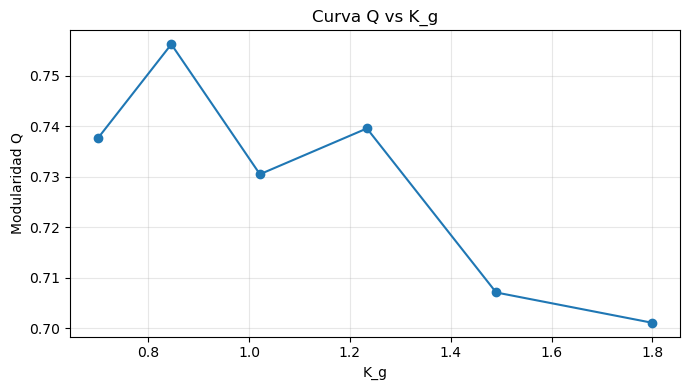

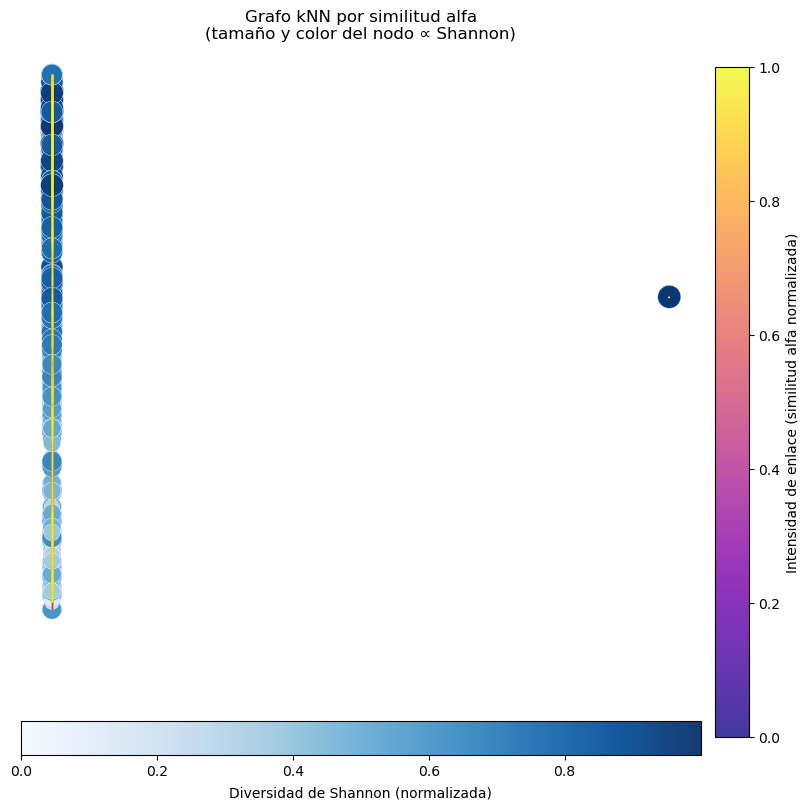

In [15]:
# Bloque 10: Visualizaciones
import matplotlib.pyplot as plt
import numpy as np

# --- 10.1 Curva Q vs Kg ---
if not results['grid_df'].empty:
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(results['grid_df']['Kg'], results['grid_df']['Q'], marker='o')
    ax.set_xlabel('K_g')
    ax.set_ylabel('Modularidad Q')
    ax.set_title('Curva Q vs K_g')
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    plt.show()
else:
    print("No hay resultados para graficar Q vs K_g.")

# --- 10.2 Grafo kNN sobre similitud alfa con barras de color ---
try:
    # 1) Construcción del kNN (mutuo si es posible)
    W_alpha_vis = build_knn_graph_from_dense(sim_alpha, topk=min(10, TOPK), mutual=True)
    if W_alpha_vis.nnz == 0:
        W_alpha_vis = build_knn_graph_from_dense(sim_alpha, topk=min(12, TOPK + 2), mutual=False)

    # 2) Tamaños y colores de nodos a partir de Shannon
    sh = alpha_df['shannon'].astype(float).to_numpy()
    sh_min, sh_max = float(np.min(sh)), float(np.max(sh))
    sh_norm = (sh - sh_min) / (sh_max - sh_min + 1e-8)  # [0,1]
    node_sizes = 60 + 220 * sh_norm
    node_colors = sh_norm  # mapeo directo a colormap

    # 3) Si hay networkx disponible, úsalo con compatibilidad de versión
    use_nx = ('nx' in globals()) and (nx is not None)
    if use_nx:
        # Compatibilidad NX2/NX3
        _from_sparse = getattr(nx, "from_scipy_sparse_array",
                               getattr(nx, "from_scipy_sparse_matrix", None))
        if _from_sparse is None:
            raise AttributeError("NetworkX no ofrece from_scipy_sparse_* en esta versión.")
        G_vis = _from_sparse(W_alpha_vis)
        for (u, v, d) in G_vis.edges(data=True):
            d['weight'] = float(d.get('weight', 1.0))

        try:
            pos = nx.spring_layout(G_vis, seed=GLOBAL_SEED)
        except Exception:
            pos = nx.spectral_layout(G_vis)

        import matplotlib as mpl
        from matplotlib.collections import LineCollection

        edges = list(G_vis.edges(data=True))
        if edges:
            weights = np.array([e[2].get('weight', 1.0) for e in edges], dtype=float)
            w_min, w_max = float(np.min(weights)), float(np.max(weights))
            w_norm = (weights - w_min) / (w_max - w_min + 1e-12)
            segs = [ [pos[u], pos[v]] for u, v, _ in edges ]
            lc = LineCollection(segs, array=w_norm, cmap='viridis', linewidths=0.8, alpha=0.8)

        fig, ax = plt.subplots(figsize=(8.2, 8.2))
        sc = ax.scatter(
            [pos[i][0] for i in range(len(sh))],
            [pos[i][1] for i in range(len(sh))],
            s=node_sizes, c=node_colors, cmap='Blues',
            edgecolors='white', linewidths=0.3, alpha=0.95
        )

        # Aristas
        if edges:
            ax.add_collection(lc)
            cbar_e = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.02)
            cbar_e.set_label('Intensidad de enlace (similitud alfa normalizada)', rotation=90)

        # --- BARRA DE COLOR HORIZONTAL (nodos) ---
        cbar_n = fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=0.12)
        cbar_n.set_label('Diversidad de Shannon (normalizada)', rotation=0, labelpad=5)

        # Resaltar nodos aislados
        deg = dict(G_vis.degree())
        iso_idx = [i for i, d in deg.items() if d == 0]
        if len(iso_idx) > 0:
            ax.scatter(
                [pos[i][0] for i in iso_idx],
                [pos[i][1] for i in iso_idx],
                s=node_sizes[iso_idx]*1.05, facecolors='none', edgecolors='crimson', linewidths=1.0,
                label='Aislados'
            )
            ax.legend(loc='upper left', frameon=False)

        ax.set_title('Grafo kNN por similitud alfa\n(tamaño y color del nodo ∝ Shannon)')
        ax.set_axis_off()
        fig.tight_layout()
        plt.show()
        

    else:
        # --- Fallback sin networkx ---
        from scipy.sparse import csgraph
        from scipy.sparse.linalg import eigsh
        L = csgraph.laplacian(W_alpha_vis, normed=True)
        try:
            vals, vecs = eigsh(L, k=3, sigma=0.0, which='LM')
            idx = np.argsort(vals)
            coords = vecs[:, idx[1:3]]
            x, y = coords[:, 0], coords[:, 1]
        except Exception:
            rng = np.random.default_rng(GLOBAL_SEED)
            x = rng.normal(size=W_alpha_vis.shape[0])
            y = rng.normal(size=W_alpha_vis.shape[0])

        coo = W_alpha_vis.tocoo()
        w = coo.data.astype(float)
        if w.size > 0:
            w_min, w_max = float(np.min(w)), float(np.max(w))
            w_norm = (w - w_min) / (w_max - w_min + 1e-12)

        fig, ax = plt.subplots(figsize=(8.2, 8.2))
        if w.size > 0:
            from matplotlib.collections import LineCollection
            segs = [ [(x[u], y[u]), (x[v], y[v])] for u, v in zip(coo.row, coo.col) ]
            lc = LineCollection(segs, array=w_norm, cmap='plasma', linewidths=0.8, alpha=0.8)
            ax.add_collection(lc)
            cbar_e = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.02)
            cbar_e.set_label('Intensidad de enlace (similitud alfa normalizada)', rotation=90)

        sc = ax.scatter(x, y, s=node_sizes, c=node_colors, cmap='Blues',
                        edgecolors='white', linewidths=0.3, alpha=0.95)
        # --- BARRA DE COLOR HORIZONTAL ABAJO ---
        cbar_n = fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=0.12)
        cbar_n.set_label('Diversidad de Shannon (normalizada)', rotation=0, labelpad=5)

        deg = np.asarray(W_alpha_vis.getnnz(axis=1)).ravel()
        iso = np.where(deg == 0)[0]
        if iso.size > 0:
            ax.scatter(x[iso], y[iso], s=node_sizes[iso]*1.05, facecolors='none',
                       edgecolors='crimson', linewidths=1.0, label='Aislados')
            ax.legend(loc='upper left', frameon=False)

        ax.set_title('Grafo kNN por similitud alfa\n(tamaño y color del nodo ∝ Shannon)')
        ax.set_axis_off()
        fig.tight_layout()
        plt.show()

except Exception as e:
    print(f"No se pudo dibujar el grafo de similitud alfa: {e}")




Error en rejilla NMI Kg=0.8, alpha=0.12: 'Graph' object has no attribute 'shape'
Error en rejilla NMI Kg=0.8, alpha=0.18: 'Graph' object has no attribute 'shape'
Error en rejilla NMI Kg=0.8, alpha=0.24: 'Graph' object has no attribute 'shape'
Error en rejilla NMI Kg=1.131370849898476, alpha=0.12: 'Graph' object has no attribute 'shape'
Error en rejilla NMI Kg=1.131370849898476, alpha=0.18: 'Graph' object has no attribute 'shape'
Error en rejilla NMI Kg=1.131370849898476, alpha=0.24: 'Graph' object has no attribute 'shape'
Error en rejilla NMI Kg=1.6, alpha=0.12: 'Graph' object has no attribute 'shape'
Error en rejilla NMI Kg=1.6, alpha=0.18: 'Graph' object has no attribute 'shape'
Error en rejilla NMI Kg=1.6, alpha=0.24: 'Graph' object has no attribute 'shape'


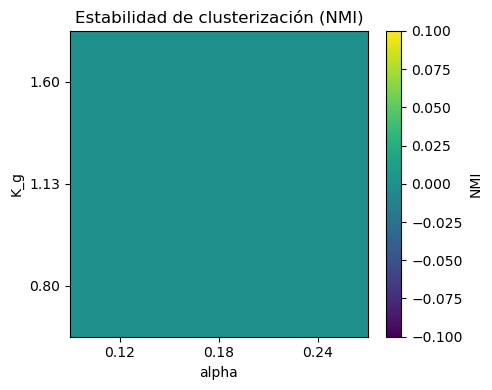

In [19]:

# Bloque 11: Estabilidad de clusterización (NMI)
from sklearn.metrics import normalized_mutual_info_score as nmi_score
import numpy as np
import matplotlib.pyplot as plt

Kg_vals_lite = np.geomspace(0.8, 1.6, 3)
alpha_vals_lite = np.linspace(0.12, 0.24, 3)
kuramoto_lite = kuramoto_defaults.copy()
kuramoto_lite.update({'T':800, 'burn':320})
phase_affinity_lite = phase_affinity_defaults.copy()
phase_affinity_lite.update({'stride':4, 'chunk_n':128})
labels_grid={}
for Kg in Kg_vals_lite:
    for alpha_val in alpha_vals_lite:
        try:
            phases_tmp = simulate_kuramoto(results['W_fused'], Kg=Kg, **kuramoto_lite)
            aff_tmp = phase_affinity(phases_tmp, **phase_affinity_lite)
            W_tmp = build_knn_graph_from_dense(aff_tmp, topk=8, mutual=False)
            lbls, Qtmp, method_tmp = cluster_graph(W_tmp, ['louvain','label_propagation','leiden'], seed=kuramoto_lite['seed'])
            labels_grid[(Kg, alpha_val)] = lbls
        except Exception as e:
            print(f"Error en rejilla NMI Kg={Kg}, alpha={alpha_val}: {e}")
            labels_grid[(Kg, alpha_val)] = np.zeros(results['shape_used'][1], dtype=int)

nmi_matrix=np.zeros((len(Kg_vals_lite), len(alpha_vals_lite)))
for i, Kg in enumerate(Kg_vals_lite):
    for j, alpha_val in enumerate(alpha_vals_lite):
        ref_labels = labels_grid[(Kg_vals_lite[0], alpha_vals_lite[0])]
        curr_labels = labels_grid[(Kg, alpha_val)]
        if len(set(ref_labels))==1 or len(set(curr_labels))==1:
            nmi=0.0
        else:
            nmi = nmi_score(ref_labels, curr_labels)
        nmi_matrix[i,j] = nmi
plt.figure(figsize=(5,4))
im=plt.imshow(nmi_matrix, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(im, label='NMI')
plt.xticks(range(len(alpha_vals_lite)), [f"{a:.2f}" for a in alpha_vals_lite])
plt.yticks(range(len(Kg_vals_lite)), [f"{k:.2f}" for k in Kg_vals_lite])
plt.xlabel('alpha')
plt.ylabel('K_g')
plt.title('Estabilidad de clusterización (NMI)')
plt.tight_layout()
plt.show()


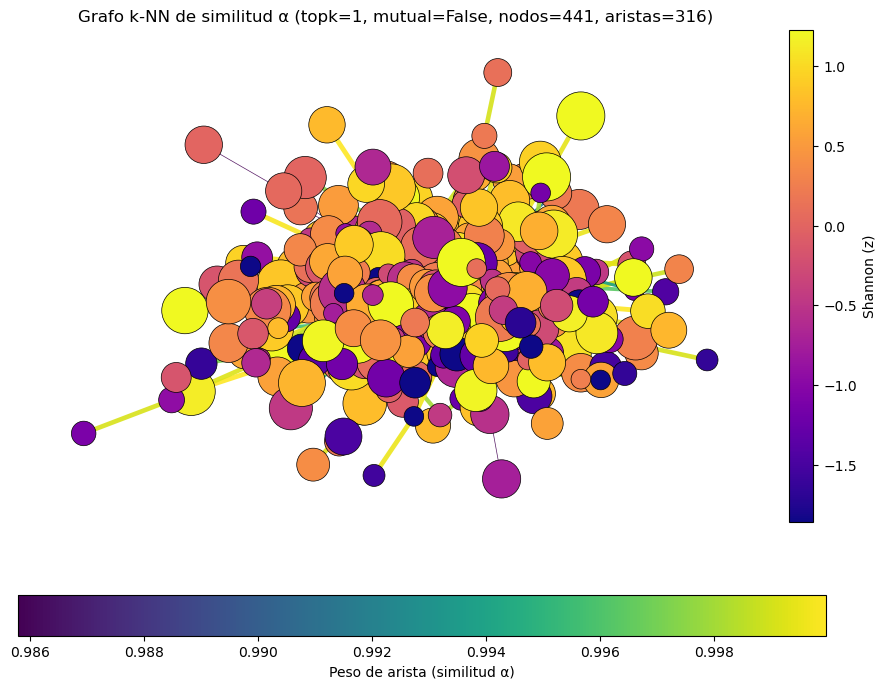

In [17]:
# Bloque 12: Grafo k-NN desde la matriz de similitud alfa
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def build_knn_graph_from_dense(sim: np.ndarray, topk: int = 10, mutual: bool = True, weight_min: float = 0.0):
    """
    Construye un grafo no dirigido a partir de una matriz densa de similitud.
    - topk: número de vecinos más similares por nodo.
    - mutual: si True, conserva la arista solo si la relación es recíproca (i en top-k de j y j en top-k de i).
    - weight_min: umbral mínimo del peso de arista para mantenerla.
    """
    n = sim.shape[0]
    # Evitar self-loops
    np.fill_diagonal(sim, 0.0)

    # Índices de top-k por fila
    topk = max(1, min(topk, n-1))
    idx = np.argpartition(-sim, kth=topk-1, axis=1)[:, :topk]

    G = nx.Graph()
    G.add_nodes_from(range(n))

    if mutual:
        # Conjunto de pares recíprocos
        for i in range(n):
            for j in idx[i]:
                if i == j:
                    continue
                # reciprocidad: i ∈ topk(j)
                if i in idx[j]:
                    w = float(sim[i, j])
                    if w >= weight_min:
                        # Añadir una sola vez con i<j
                        u, v = (i, j) if i < j else (j, i)
                        if G.has_edge(u, v):
                            # conservar el mayor peso si se repite
                            G[u][v]['weight'] = max(G[u][v]['weight'], w)
                        else:
                            G.add_edge(u, v, weight=w)
    else:
        # Unir sin exigir reciprocidad
        for i in range(n):
            for j in idx[i]:
                if i == j:
                    continue
                w = float(sim[i, j])
                if w >= weight_min:
                    u, v = (i, j) if i < j else (j, i)
                    if G.has_edge(u, v):
                        G[u][v]['weight'] = max(G[u][v]['weight'], w)
                    else:
                        G.add_edge(u, v, weight=w)
    return G

def plot_alpha_knn_graph(sim_alpha: np.ndarray,
                         alpha_df: pd.DataFrame,
                         sample_ids,
                         topk: int = 10,
                         mutual: bool = True,
                         weight_min: float = 0.0,
                         max_nodes: int = 200,
                         seed: int = 42):
    """
    Visualiza el grafo k-NN de similitud alfa.
    - Colores de nodos: shannon_z
    - Tamaño de nodos: riqueza (richness) con escala suave
    - Colores de aristas: peso de similitud (sim_alpha)
    - Barra de color de aristas horizontal (abajo); barra de nodos vertical (derecha)
    - Submuestreo si el número de nodos excede max_nodes (elige los de mayor 'fuerza' en sim_alpha)
    """
    n = sim_alpha.shape[0]
    if n < 2:
        print("No hay suficientes nodos para graficar.")
        return

    # Submuestreo si el grafo es muy grande: tomar los nodos con mayor "strength" (suma de similitudes)
    if n > max_nodes:
        strength = sim_alpha.sum(axis=1)
        keep_idx = np.argsort(-strength)[:max_nodes]
        keep_idx = np.sort(keep_idx)

        sim_sub = sim_alpha[np.ix_(keep_idx, keep_idx)]
        alpha_sub = alpha_df.iloc[keep_idx].reset_index(drop=True)
        sample_sub = [sample_ids[i] for i in keep_idx]
        print(f"Submuestreo: {n} → {len(keep_idx)} nodos (por fuerza de similitud).")
    else:
        sim_sub = sim_alpha
        alpha_sub = alpha_df.copy().reset_index(drop=True)
        sample_sub = list(sample_ids)

    # Construir grafo k-NN
    G = build_knn_graph_from_dense(sim_sub, topk=topk, mutual=mutual, weight_min=weight_min)

    # Preparar atributos visuales de nodos
    # Colores por shannon_z; tamaños por richness
    shannon_z = alpha_sub['shannon_z'].to_numpy()
    rich = alpha_sub['richness'].to_numpy()

    # Normalizaciones para un rango visual agradable
    # Tamaño de nodos: 100..1000 puntos
    rmin, rmax = np.percentile(rich, [5, 95]) if len(rich) > 10 else (rich.min(), rich.max() + 1e-9)
    rscale = (np.clip(rich, rmin, rmax) - rmin) / (max(rmax - rmin, 1e-9))
    node_sizes = 200 + 1000 * rscale

    # Colores de nodos desde shannon_z (recortar percentiles extremos para robustez)
    smin, smax = np.percentile(shannon_z, [5, 95]) if len(shannon_z) > 10 else (shannon_z.min(), shannon_z.max() + 1e-9)
    s_norm = Normalize(vmin=smin, vmax=smax)
    node_cmap = plt.cm.plasma
    node_colors = node_cmap(s_norm(shannon_z))

    # Posicionamiento (Kamada-Kawai es estable para pesos)
    # Si hay pesos, los invertimos para que mayor similitud → distancia más corta
    # networkx espera 'weight' como "coste", por eso usamos 1/weight para KK si corresponde
    pos = None
    if G.number_of_edges() > 0:
        # Pesos invertidos con protección contra ceros
        inv_weights = {}
        for u, v, d in G.edges(data=True):
            w = max(d.get('weight', 1e-12), 1e-12)
            inv_weights[(u, v)] = 1.0 / w
        # KK usa 'weight' desde los atributos; creamos una copia temporal con pesos invertidos
        H = nx.Graph()
        H.add_nodes_from(G.nodes())
        for (u, v), invw in inv_weights.items():
            H.add_edge(u, v, weight=invw)
        pos = nx.kamada_kawai_layout(H)
    else:
        pos = nx.spring_layout(G, seed=seed)

    # Preparar colores de aristas por peso
    edge_weights = np.array([d.get('weight', 0.0) for _, _, d in G.edges(data=True)]) if G.number_of_edges() else np.array([])
    if edge_weights.size > 0:
        wmin, wmax = np.percentile(edge_weights, [5, 95]) if edge_weights.size > 10 else (edge_weights.min(), edge_weights.max() + 1e-12)
        e_norm = Normalize(vmin=wmin, vmax=wmax)
        edge_cmap = plt.cm.viridis
        edge_colors = edge_cmap(e_norm(edge_weights))
        # Grosor de aristas con escala suave
        edge_widths = 0.5 + 3.0 * ((np.clip(edge_weights, wmin, wmax) - wmin) / max(wmax - wmin, 1e-12))
    else:
        edge_colors = None
        edge_widths = 0.5

    # Dibujo
    fig, ax = plt.subplots(figsize=(9, 7))

    if G.number_of_edges() > 0:
        nx.draw_networkx_edges(
            G, pos,
            edge_color=edge_colors,
            width=edge_widths,
            alpha=0.9,
            ax=ax
        )

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        linewidths=0.5,
        edgecolors='k',
        ax=ax
    )

    # Etiquetas opcionales (desactivadas por defecto para claridad)
    # labels = {i: sample_sub[i] for i in G.nodes()}
    # nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, ax=ax)

    ax.set_title(f"Grafo k-NN de similitud α (topk={topk}, mutual={mutual}, nodos={G.number_of_nodes()}, aristas={G.number_of_edges()})")
    ax.set_axis_off()

    # ---- Barras de color ----
    # 1) Aristas (abajo, horizontal) → similitud
    if edge_weights.size > 0:
        sm_e = ScalarMappable(norm=e_norm, cmap=plt.cm.viridis)
        sm_e.set_array([])
        cbar_e = plt.colorbar(sm_e, ax=ax, orientation='horizontal', fraction=0.08, pad=0.12)
        cbar_e.set_label("Peso de arista (similitud α)")

    # 2) Nodos (derecha, vertical) → Shannon (z)
    sm_n = ScalarMappable(norm=s_norm, cmap=plt.cm.plasma)
    sm_n.set_array([])
    cbar_n = plt.colorbar(sm_n, ax=ax, orientation='vertical', fraction=0.046, pad=0.02)
    cbar_n.set_label("Shannon (z)")

    plt.tight_layout()
    plt.show()

# === Ejecutar visualización ===
# Parámetros ajustables:
TOPK = 1       # vecinos por nodo
MUTUAL = False      # arista solo si es recíproca
WEIGHT_MIN = 0.0   # umbral mínimo de peso
MAX_NODES = 441    # submuestreo si hay demasiados nodos

plot_alpha_knn_graph(
    sim_alpha=sim_alpha,
    alpha_df=alpha_df,
    sample_ids=sample_ids,
    topk=TOPK,
    mutual=MUTUAL,
    weight_min=WEIGHT_MIN,
    max_nodes=MAX_NODES,
    seed=0
)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import imageio
from pathlib import Path

# Carpeta de resultados
RESULTS_DIR = Path("Resultados")
RESULTS_DIR.mkdir(exist_ok=True)

# Parámetros
topk_values = [4, 6, 8, 10, 12]
mutual_values = [True, False]
frames = []
GLOBAL_SEED = 30

cmap_nodes = plt.cm.plasma
cmap_edges = plt.cm.viridis

fig, ax = plt.subplots(figsize=(7.5, 7.5))

def draw_alpha_graph(topk=8, mutual=True):
    ax.clear()

    # --- Generar matriz kNN ---
    W_alpha_vis = build_knn_graph_from_dense(sim_alpha, topk=topk, mutual=mutual)

    # --- Convertir a grafo NX (solo si no lo es ya) ---
    if hasattr(W_alpha_vis, "shape"):
        G = nx.from_scipy_sparse_array(W_alpha_vis)
    else:
        G = W_alpha_vis

    if len(G) == 0:
        print(f"⚠️ Grafo vacío para topk={topk}, mutual={mutual}")
        return

    # --- Atributos visuales de nodos ---
    sh = alpha_df["shannon"].astype(float).to_numpy()
    sh_norm = (sh - sh.min()) / (sh.max() - sh.min() + 1e-9)
    node_sizes = 60 + 220 * sh_norm
    node_colors = cmap_nodes(sh_norm)

    # --- Layout y pesos ---
    pos = nx.spring_layout(G, seed=GLOBAL_SEED)
    weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)])
    if len(weights) > 0:
        norm_edges = Normalize(vmin=np.percentile(weights, 5),
                               vmax=np.percentile(weights, 95))
        edge_colors = cmap_edges(norm_edges(weights))
    else:
        edge_colors = "lightgray"

    # --- Dibujar ---
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.8, width=1.0, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes,
                           edgecolors="white", linewidths=0.3, ax=ax)
    ax.set_title(f"Grafo α - topk={topk}, mutual={mutual}", fontsize=11)
    ax.axis("off")


# --- Generar los frames ---
for mutual in mutual_values:
    for k in topk_values:
        draw_alpha_graph(topk=k, mutual=mutual)
        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(frame.copy())

plt.close(fig)

# --- Guardar GIF ---
gif_path = RESULTS_DIR / "alpha_knn_evolution.gif"
imageio.mimsave(gif_path, frames, duration=[30] * len(frames))
print(f"✅ GIF guardado en: {gif_path}")


✅ GIF guardado en: Resultados\alpha_knn_evolution.gif
